# Algoritmos de Navegación: Alternativas a RRT y RRT*
**Asignatura:** Inteligencia Artificial para la Robótica (Curso 2025/26)  
**Autores:** Liborio Ángel Román Montes & Andrés Rubio Ramos

**Estructura del Proyecto:**
- `src/`: Módulos principales (`rrt.py`, `structures.py`, `env.py`).
- `notebooks/`: Scripts de ejecución y experimentos.
- `results/figures/`: Gráficas y visualizaciones generadas.
- `results/tests/`: Datos brutos en formato `.csv`.
- `results/animations/`: Animaciones generadas.

In [1]:
import sys, os, math, importlib
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display
import random
from collections import deque
import copy

# Configuración de rutas locales ( notebook en 'notebooks/', módulos en 'src/' )
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import rrt, structures, env
importlib.reload(rrt); importlib.reload(structures); importlib.reload(env)

from structures import Point, Segment, Tree, Node
from env import Scenario, Obstacle
from rrt import RRT, RRT_star, Informed_RRT_star, BIT_star

# Creación de directorios de resultados si no existen
os.makedirs('../results/figures', exist_ok=True)
os.makedirs('../results/tests', exist_ok=True)
os.makedirs('../results/animations', exist_ok=True)

### 2. Generación Aleatoria de Escenarios y Validación de Resolubilidad
Para evaluar el rendimiento de los algoritmos bajo condiciones replicables, se han implementado funciones que automatizan la creación de entornos sintéticos. 

Estas herramientas permiten:
* **Reproducibilidad**: Uso de semillas aleatorias (`seeds`) para garantizar que todos los algoritmos se evalúen en el mismo mapa.
* **Garantía de éxito**: Antes de iniciar la planificación, se valida el escenario mediante un algoritmo de **búsqueda en anchura (BFS)** sobre una rejilla discretizada. Solo se aceptan entornos donde se confirma la existencia de al menos un camino viable para el radio del robot.
* **Parámetros configurables**: Control sobre el área de trabajo, densidad de obstáculos y distancia mínima entre el inicio y la meta.

In [2]:
# =============================================================================
# FUNCIONES DE SOPORTE PARA EL MODELADO DEL ESCENARIO Y VALIDACIÓN DE RUTAS
# =============================================================================

def _random_point_in_bounds(xmin, xmax, ymin, ymax, margin=0.0):
    """
    Genera un punto aleatorio (Point) dentro de los límites del escenario 
    respetando un margen de seguridad respecto a los bordes.
    """
    return Point(
        random.uniform(xmin + margin, xmax - margin),
        random.uniform(ymin + margin, ymax - margin),
    )

def _is_free_point(scenario, p, robot_radius):
    """
    Verifica si un punto específico está libre de colisiones con los 
    obstáculos del escenario para un radio de robot determinado.
    """
    return not scenario.collision_with_robot(p, robot_radius)

def _reachable_bfs_grid(scenario, start, goal, robot_radius, xmin, xmax, ymin, ymax, grid_n=60):
    """
    Comprueba la conectividad aproximada entre el inicio y la meta mediante BFS.
    [cite_start]Este paso garantiza que el escenario aleatorio generado sea resoluble[cite: 660].
    """
    def to_idx(p):
        # Mapea coordenadas espaciales continuas a índices de la rejilla discretizada
        ix = int((p.x - xmin) / (xmax - xmin) * (grid_n - 1))
        iy = int((p.y - ymin) / (ymax - ymin) * (grid_n - 1))
        return max(0, min(grid_n - 1, ix)), max(0, min(grid_n - 1, iy))

    def center(ix, iy):
        # Obtiene el centro geométrico de una celda de la rejilla
        return Point(xmin + (ix + 0.5) * (xmax - xmin) / grid_n,
                     ymin + (iy + 0.5) * (ymax - ymin) / grid_n)

    # Marcado de celdas ocupadas en la rejilla de ocupación
    blocked = np.zeros((grid_n, grid_n), dtype=bool)
    for ix in range(grid_n):
        for iy in range(grid_n):
            if scenario.collision_with_robot(center(ix, iy), robot_radius):
                blocked[ix, iy] = True

    sx, sy = to_idx(start)
    gx, gy = to_idx(goal)
    
    # Validación inicial: los puntos extremos no deben estar en celdas bloqueadas
    if blocked[sx, sy] or blocked[gx, gy]: return False

    # Búsqueda en anchura (BFS) para encontrar un camino en la rejilla
    q = deque([(sx, sy)])
    visited = np.zeros((grid_n, grid_n), dtype=bool)
    visited[sx, sy] = True
    neigh = [(1,0), (-1,0), (0,1), (0,-1)] # Movimientos cardinales

    while q:
        x, y = q.popleft()
        if (x, y) == (gx, gy): return True
        for dx, dy in neigh:
            nx, ny = x + dx, y + dy
            # Verificación de límites de la rejilla, estado de visita y colisiones
            if 0 <= nx < grid_n and 0 <= ny < grid_n and not visited[nx, ny] and not blocked[nx, ny]:
                visited[nx, ny] = True
                q.append((nx, ny))
    return False

def generate_random_scenario(xmin=-30, xmax=30, ymin=-30, ymax=30, robot_radius=3.5, 
                             n_obstacles_range=(3, 8), size_range=(4, 14), max_tries=200, 
                             grid_n=60, min_start_goal_dist=20.0, seed=None):
    """
    Genera un escenario aleatorio completo (Scenario, Start, Goal) que garantiza 
    [cite_start]la existencia de al menos una ruta viable para el robot[cite: 660].
    """
    if seed is not None:
        # [cite_start]Configuración de semillas para garantizar la reproducibilidad del experimento [cite: 659]
        random.seed(seed); np.random.seed(seed)
    
    # Margen mínimo basado en el radio del robot para evitar bloqueos inmediatos
    margin = max(robot_radius * 1.5, 1.0)
    
    for attempt in range(max_tries):
        # [cite_start]Creación aleatoria de obstáculos rectangulares [cite: 658]
        obstacles = [Obstacle(random.uniform(xmin, xmax - 14), random.uniform(ymin, ymax - 14), 
                             random.uniform(*size_range), random.uniform(*size_range)) 
                     for _ in range(random.randint(*n_obstacles_range))]
        scenario = Scenario(obstacles, xmin, xmax, ymin, ymax)
        
        # Intento de ubicar un punto de inicio válido
        start = None
        for _ in range(200):
            p = _random_point_in_bounds(xmin, xmax, ymin, ymax, margin)
            if _is_free_point(scenario, p, robot_radius):
                start = p
                break
        if start is None: continue

        # [cite_start]Intento de ubicar una meta válida con una separación mínima respecto al inicio [cite: 666]
        goal = None
        for _ in range(400):
            p = _random_point_in_bounds(xmin, xmax, ymin, ymax, margin)
            if _is_free_point(scenario, p, robot_radius) and p.distance(start) >= min_start_goal_dist:
                goal = p
                break
        if goal is None: continue

        # [cite_start]Validación técnica final: ¿Es el problema resoluble mediante BFS? [cite: 660]
        if _reachable_bfs_grid(scenario, start, goal, robot_radius, xmin, xmax, ymin, ymax, grid_n):
            return scenario, start, goal
            
    raise RuntimeError("No se pudo generar un escenario válido tras agotar el número máximo de intentos.")

### 3. Visualización y Validación Unitaria de Planificadores
Esta función auxiliar permite realizar ejecuciones individuales de los algoritmos para validar su comportamiento y visualizar la exploración del espacio de estados.

**Capacidades de la función:**
* **Ejecución iterativa**: Gestiona el bucle de expansión del árbol para cualquier clase de planificador (`RRT`, `RRT*`, `Informed RRT*` o `BIT*`).
* **Cálculo de Optimalidad**: Recupera el camino con menor coste acumulado hacia la meta.
* **Inspección Visual**: Renderiza el escenario completo, incluyendo obstáculos, la estructura de ramas del árbol y resalta la trayectoria final encontrada.

In [3]:
def simple_test(scenario, algo_cls, start, goal, iterations, edge_length, robot_radius, name):
    """
    Realiza una ejecución de prueba de un algoritmo y visualiza el resultado gráfico.
    
    Parámetros:
        scenario: Objeto Scenario que contiene obstáculos y límites.
        algo_cls: Clase del algoritmo de planificación a evaluar.
        start/goal: Puntos geométricos de origen y destino.
        iterations: Límite de expansiones del árbol.
        edge_length: Longitud máxima de los arcos (paso de extensión).
        robot_radius: Radio de seguridad del robot para colisiones.
        name: Etiqueta descriptiva para el gráfico y logs.
    """
    print(f"\n===== {name} =====")
    
    # Instanciación del algoritmo: los tipos informados requieren el conocimiento del objetivo desde el inicio
    algo = algo_cls(start.x, start.y) if name in ["RRT", "RRT*"] else algo_cls(start.x, start.y, goal.x, goal.y)
    
    # Proceso incremental de expansión del árbol de búsqueda
    for i in range(iterations):
        algo.iterate(scenario, edge_length, robot_radius)
    
    # [cite_start]Extracción de la trayectoria optimizada según el coste acumulado [cite: 15]
    path = algo.get_optimal_path(goal, edge_length)
    
    # Gestión de la figura: reutiliza el eje del escenario si existe o crea uno nuevo
    if hasattr(scenario, 'ax'):
        fig, ax = scenario.fig, scenario.ax
    else:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(scenario.xmin, scenario.xmax)
        ax.set_ylim(scenario.ymin, scenario.ymax)
        ax.set_aspect('equal', adjustable='box')
        ax.grid()
        # [cite_start]Representación de los obstáculos rectangulares en el lienzo [cite: 15]
        for o in scenario.obstacles:
            o.draw(ax)

    # Representación visual de la conectividad del árbol (aristas entre nodos)
    for n in algo.nodes:
        if n.parent:
            Segment(n.parent.point, n.point).draw(ax)

    title = f"{name} - {len(algo.nodes)} nodos"

    # Si se ha hallado una ruta válida, se calcula su coste y se resalta gráficamente
    if path:
        # [cite_start]El coste final incluye el coste acumulado hasta el umbral de meta más la distancia residual [cite: 15]
        longitud = path[-1].cost + path[-1].point.distance(goal)
        title += f" - Longitud: {longitud:.2f}"
        
        # [cite_start]Dibujado de la trayectoria final en color rojo para contraste [cite: 15]
        for i in range(len(path) - 1):
            Segment(path[i].point, path[i+1].point).draw(ax, color='red', alpha=0.9, linewidth=2)
        print(f"✓ Camino encontrado. Costo: {longitud:.2f}")
    
    # [cite_start]Dibujado de los puntos clave: inicio (azul) y objetivo (dorado) [cite: 15]
    start.draw(ax, color='blue', size=10)
    goal.draw(ax, color='gold', size=10)
    
    plt.title(title)
    
    # Nota: Si se desea exportar el resultado, se debe usar la ruta: ../results/figures/
    plt.show()
    
    return path

### 4. Ejecución del Banco de Pruebas Comparativo
En esta sección se realiza la comparativa directa entre los cuatro algoritmos implementados bajo un escenario idéntico. Se utiliza una semilla (`seed=0`) para garantizar que la disposición de obstáculos, el punto de inicio y la meta sean los mismos para todos los planificadores.

**Algoritmos evaluados:**
* **RRT (Estándar)**: Centrado en la exploración rápida; suele encontrar soluciones rápidamente pero de alta sub-optimalidad (trayectorias en "zigzag").
* **RRT***: Introduce el proceso de **rewiring** para garantizar la convergencia asintótica hacia la ruta más corta.
* **Informed RRT***: Optimiza el muestreo mediante una heurística elipsoidal una vez hallada la primera solución, acelerando el refinamiento del camino.
* **BIT***: Utiliza procesamiento por lotes y búsqueda heurística sobre grafos implícitos, destacando por su eficiencia en escenarios complejos.

Al final de las pruebas, se genera un resumen comparativo de la longitud del camino (coste) obtenido por cada variante.

In [ ]:
# =============================================================================
# BLOQUE DE EJECUCIÓN EXPERIMENTAL: COMPARATIVA DIRECTA
# =============================================================================

print("="*60)
print("COMPARATIVA DE ALGORITMOS RRT")
print("="*60)

# Generación de un escenario aleatorio con parámetros estándar para el benchmarking
# Se utiliza seed=0 para asegurar la repetibilidad de los resultados experimentales
scenario, start, goal = generate_random_scenario(
    xmin=-50, xmax=50, ymin=-50, ymax=50, 
    robot_radius=1.5, seed=0
)

# Prueba del algoritmo RRT estándar (Exploración pura)
# Nota: Las figuras generadas por simple_test deben guardarse en ../results/figures/ si se activa el guardado
path_rrt = simple_test(
    copy.deepcopy(scenario), RRT, start, goal, 
    iterations=800, edge_length=5.0, robot_radius=1.5, name="RRT"
)

# Prueba del algoritmo RRT* (Optimización mediante re-cableado)
path_rrt_star = simple_test(
    copy.deepcopy(scenario), RRT_star, start, goal, 
    iterations=800, edge_length=5.0, robot_radius=1.5, name="RRT*"
)

# Prueba del algoritmo Informed RRT* (Muestreo elipsoidal dirigido)
path_informed = simple_test(
    copy.deepcopy(scenario), Informed_RRT_star, start, goal, 
    iterations=800, edge_length=5.0, robot_radius=1.5, name="Informed RRT*"
)

# Prueba del algoritmo BIT* (Batch Informed Trees - Búsqueda heurística por lotes)
path_bit = simple_test(
    copy.deepcopy(scenario), BIT_star, start, goal, 
    iterations=800, edge_length=5.0, robot_radius=1.5, name="BIT*"
)

# --- Generación de Resumen de Resultados ---
print("\n" + "="*60)
print("RESUMEN DE COSTES (DISTANCIA EUCLÍDEA)")
print("="*60)

costs = []
for name, path in [("RRT", path_rrt), ("RRT*", path_rrt_star), 
                   ("Informed RRT*", path_informed), ("BIT*", path_bit)]:
    if path is not None:
        # Se extrae el coste acumulado final registrado en el último nodo del camino
        print(f"{name:20s}: cost={path[-1].cost:.2f}")
        costs.append(path[-1].cost)
    else:
        print(f"{name:20s}: NO ENCONTRADO")

# Identificación automática del planificador más eficiente en términos de longitud de trayectoria
if costs:
    print(f"\nMejor algoritmo (menor coste): {min(costs):.2f}")

### 5. Funciones de Visualización Dinámica y Generación de Animaciones
Para facilitar el análisis del comportamiento de los algoritmos "any-time", se han implementado herramientas de visualización que permiten observar el proceso de expansión en tiempo real.

* **Visualización de Heurísticas**: La función `draw_ellipse` representa las regiones de muestreo informado (elipsoides) que utilizan Informed RRT* y BIT* para acotar el espacio de búsqueda.
* **Renderizado por Cuadros**: `update_algorithm_ax` gestiona la actualización de cada fotograma, mostrando no solo el árbol y el camino óptimo, sino también feedback visual sobre intentos de conexión fallidos (colisiones) y muestras activas en el lote (batch).
* **Exportación de Resultados**: `generate_single_algorithm_gif` automatiza la creación de archivos .gif para documentar la evolución del planificador.

In [5]:
def draw_ellipse(ax: plt.Axes, start: Point, goal: Point, cost: float, color: str, ls: str = '--'):
    """
    Dibuja una elipse de muestreo informado basada en el coste actual.
    Los focos de la elipse se sitúan en las coordenadas de 'start' y 'goal'.
    """
    # Evitar dibujar si el costo es infinito o excesivamente alto (fase inicial)
    if cost is None or math.isinf(cost) or cost > 1e6: 
        return
        
    c_min = start.distance(goal)
    # Corrección para evitar errores numéricos si el coste es marginalmente inferior a la distancia mínima
    if cost < c_min: 
        cost = c_min + 0.01 
    
    # Cálculo del centro geométrico y el ángulo de rotación para alinear la elipse con los focos
    center = ((start.x + goal.x)/2, (start.y + goal.y)/2)
    angle = math.degrees(math.atan2(goal.y - start.y, goal.x - start.x))
    
    # El semieje mayor (w) es el coste actual; el semieje menor (h) deriva de b = sqrt(a^2 - c^2)
    w = cost
    h = math.sqrt(max(0.1, cost**2 - c_min**2))
    
    # Generación del parche de la elipse sin relleno para visualizar el área de muestreo
    ellipse = patches.Ellipse(center, w, h, angle=angle, fill=False, 
                              edgecolor=color, linestyle=ls, alpha=0.6, zorder=3)
    ax.add_patch(ellipse)

def update_algorithm_ax(ax: plt.Axes, algo: Tree, scenario: Scenario, start: Point, 
                        goal: Point, frame: int, algo_name: str, 
                        edge_length: float = 5.0, robot_radius: float = 1.5):
    """
    Actualiza el estado gráfico del eje para un frame específico de la animación.
    Redibuja el entorno, el árbol actual y resalta las heurísticas específicas del algoritmo.
    """
    ax.clear()
    ax.set_xlim(scenario.xmin, scenario.xmax)
    ax.set_ylim(scenario.ymin, scenario.ymax)
    ax.set_aspect('equal', adjustable='box')
    ax.grid()
    
    # 1. Dibujar obstáculos del entorno
    for o in scenario.obstacles:
        o.draw(ax)
    
    # 2. Dibujar la estructura completa del árbol (nodos y conexiones)
    for n in algo.nodes:
        if n.parent:
            Segment(n.parent.point, n.point).draw(ax)
    
    # 3. Representación de componentes de algoritmos informados
    if "BIT" in algo_name:
        # BIT* muestra el coste de la mejor solución y el coste del lote actual
        draw_ellipse(ax, start, goal, algo.c_best, 'black', ls='-')
        draw_ellipse(ax, start, goal, algo.c_current, 'gray', ls=':')
        
        # Visualización de las muestras del lote actual pendientes de procesar
        if hasattr(algo, 'samples'):
            for p in algo.samples:
                p.draw(ax, color='gray', size=1.5, alpha=0.3)
                
    elif "Informed" in algo_name:
        # Informed RRT* visualiza el elipsoide de reducción del espacio de búsqueda
        draw_ellipse(ax, start, goal, algo.c_best, 'black', ls='-')
    
    # 4. Ejecución de una iteración del planificador
    res_n, p_att, p_p = algo.iterate(scenario, edge_length, robot_radius)
    
    # 5. Feedback visual sobre el éxito o fallo de la expansión actual
    if p_att and p_p:
        if res_n:
            # Conexión válida añadida al árbol
            Segment(p_p.point, res_n.point).draw(ax, color='lime', alpha=0.8)
        else:
            # Intento de conexión descartado por colisión
            ax.plot([p_p.point.x, p_att.x], [p_p.point.y, p_att.y], 
                    color='red', linestyle=':', alpha=0.6)
    
    title = f"{algo_name} | Paso {frame} | Nodos: {len(algo.nodes)}"

    # 6. Extracción y dibujado de la trayectoria óptima descubierta hasta el momento
    best_path = algo.get_optimal_path(goal, edge_length)
    if best_path:
        title += f" | Longitud: {best_path[-1].cost + best_path[-1].point.distance(goal):.2f}"
        for j in range(len(best_path) - 1):
            Segment(best_path[j].point, best_path[j+1].point).draw(ax, color='red', alpha=0.9, linewidth=2)
    
    # 7. Marcadores de inicio y objetivo
    start.draw(ax, color='blue', size=10)
    goal.draw(ax, color='gold', size=10)
    ax.set_title(title, fontsize=15)

def generate_single_algorithm_gif(algo_class: type, scenario: Scenario, start: Point, goal: Point, 
                                  iterations: int = 150, edge_length: float = 5.0, robot_radius: float = 1.5, 
                                  b_size: int = 30, fps: int = 10, filename: str = '../results/animations/algo.gif'):
    """
    Genera y guarda una animación en formato GIF de la ejecución de un algoritmo.
    La ruta de guardado por defecto se redirige a '../results/animations/'.
    """
    algo_name = algo_class.__name__
    # Inicialización del algoritmo según sus requerimientos de parámetros
    if algo_name in ["RRT", "RRT_star"]: 
        algo = algo_class(start.x, start.y)
    elif "BIT" in algo_name: 
        algo = algo_class(start.x, start.y, goal.x, goal.y, batch_size=b_size)
    else: 
        algo = algo_class(start.x, start.y, goal.x, goal.y)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    def update(frame):
        # Función de actualización para FuncAnimation
        update_algorithm_ax(ax, algo, scenario, start, goal, frame, algo_name, edge_length, robot_radius)
        return ax,
        
    ani = FuncAnimation(fig, update, frames=iterations, interval=1000//fps)
    
    # Persistencia de la animación en el directorio de resultados/animations
    ani.save(filename, writer=PillowWriter(fps=fps))
    plt.close()
    
    # Retorno del objeto imagen para su previsualización en el notebook
    return Image(open(filename, 'rb').read())

### 6. Generación de Pruebas Unitarias Animadas
En esta sección se ejecutan los cuatro algoritmos de planificación (`RRT`, `RRT*`, `Informed RRT*` y `BIT*`) de forma individual sobre escenarios aleatorios. 

Para cada prueba se utiliza una semilla distinta (100, 200, 300 y 400), lo que permite observar el comportamiento de los planificadores en entornos con diferentes configuraciones de obstáculos. Las animaciones resultantes se almacenan automáticamente en la carpeta de resultados para su posterior análisis visual de la exploración y convergencia.

In [ ]:
# =============================================================================
# GENERACIÓN DE TESTS INDIVIDUALES Y EXPORTACIÓN DE ANIMACIONES
# =============================================================================

print("="*60 + "\n📍 GENERANDO TESTS INDIVIDUALES\n" + "="*60)

# Configuración de semillas para garantizar escenarios únicos y rutas de salida para los archivos GIF
# Las rutas han sido modificadas para almacenarse en '../results/animations/'
seeds = [100, 200, 300, 400]
filenames = [
    '../results/animations/test_rrt.gif', 
    '../results/animations/test_rrt_star.gif', 
    '../results/animations/test_informed.gif', 
    '../results/animations/test_bit.gif'
]

# [cite_start]Definición de los planificadores a evaluar en el experimento [cite: 484, 576]
classes = [RRT, RRT_star, Informed_RRT_star, BIT_star]

# Iteración para generar un escenario aleatorio por algoritmo y exportar su comportamiento dinámico
for i in range(4):
    # [cite_start]Generación de un escenario validado que garantiza la existencia de una ruta [cite: 660]
    scen, st, gl = generate_random_scenario(seed=seeds[i], robot_radius=1.5)
    
    # [cite_start]Creación del GIF animado documentando la exploración del espacio de configuraciones [cite: 31, 283]
    gif = generate_single_algorithm_gif(
        classes[i], 
        scen, 
        st, 
        gl, 
        iterations=200, 
        filename=filenames[i]
    )
    
    # Visualización inmediata de la animación en la celda del notebook
    display(gif)

### 7. Comparativa Multipanel en Tiempo Real
Esta función genera una visualización sincronizada en una rejilla de 2x2 para comparar el comportamiento de los cuatro algoritmos (`RRT`, `RRT*`, `Informed RRT*` y `BIT*`) simultáneamente sobre el mismo escenario.

**Objetivos de esta visualización:**
* **Benchmarking equitativo**: Al utilizar el mismo escenario y semillas, se observa cómo cada lógica de planificación aborda los mismos obstáculos de manera diferente.
* **Análisis de convergencia**: Permite identificar visualmente qué algoritmos encuentran la primera solución con mayor rapidez y cuáles refinan el camino con mayor agresividad.
* **Evaluación de la densidad del árbol**: Se puede comparar la eficiencia en la gestión de nodos, observando cuántas "ramas muertas" genera cada método frente a las variantes informadas que acotan el espacio de búsqueda.

In [7]:
def generate_comparison_gif(iterations: int = 120, b_size: int = 25, 
                            random_scenario: tuple = None, fps: int = 10, seed: int = None):
    """
    Genera un GIF comparativo con los 4 algoritmos funcionando en paralelo sobre un 
    mismo escenario en una rejilla de 2x2.
    """
    # Selección o generación del escenario de prueba
    if random_scenario is not None: 
        scenario, start, goal = random_scenario
    else: 
        scenario, start, goal = generate_random_scenario(seed=seed, robot_radius=1.5)
    
    # Definición de clases y etiquetas para la comparativa
    algo_classes = [RRT, RRT_star, Informed_RRT_star, BIT_star]
    algo_names = ["RRT", "RRT*", "Informed RRT*", "BIT*"]
    
    # Inicialización de instancias y copias profundas del escenario para cada subgráfico
    algos = []
    scenarios = [copy.deepcopy(scenario) for _ in range(4)]
    
    for i, algo_cls in enumerate(algo_classes):
        # Inicialización específica según los requerimientos de cada variante
        if "BIT" in algo_names[i]: 
            algos.append(algo_cls(start.x, start.y, goal.x, goal.y, batch_size=b_size))
        elif "Informed" in algo_names[i]: 
            algos.append(algo_cls(start.x, start.y, goal.x, goal.y))
        else: 
            algos.append(algo_cls(start.x, start.y))
    
    # Configuración de la figura multipanel (2 filas, 2 columnas)
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes_flat = axes.flatten()
    
    def update(frame):
        """Función de actualización sincronizada para los 4 ejes."""
        for i in range(4):
            update_algorithm_ax(axes_flat[i], algos[i], scenarios[i], start, goal, frame, algo_names[i])
        return axes_flat
    
    # Creación de la animación integrada
    ani = FuncAnimation(fig, update, frames=iterations, interval=1000//fps)
    
    # Definición de la ruta de guardado respetando la carpeta de animaciones
    filename = '../results/animations/comparativa_final.gif'
    ani.save(filename, writer=PillowWriter(fps=fps))
    
    plt.close()
    
    # Retorno de la imagen para previsualización en el entorno Jupyter
    return Image(open(filename, 'rb').read())

In [ ]:
generate_comparison_gif(iterations=400, b_size=20, seed=5, fps=20)  # Duración de 10 minutos aprox.

### 8. Definición de Métricas y Lógica de Benchmarking Cuantitativo
Para evaluar los resultados de forma objetiva, se definen las métricas de rendimiento y la infraestructura de pruebas masivas.

**Métricas implementadas:**
* **Longitud del camino**: Suma de distancias euclidianas entre nodos de la trayectoria.
* **Suavidad (Smoothness)**: Cuantificación de los cambios angulares en cada vértice (valores bajos indican rutas más fluidas y viables mecánicamente).
* **Margen de seguridad (Clearance)**: Distancia mínima real entre el robot y el obstáculo más cercano durante el trayecto.

**Lógica de Evaluación:**
La función `evaluate_optimizer_comparison` permite ejecutar múltiples pruebas automatizadas (N ejecuciones) variando la semilla aleatoria para obtener promedios estadísticamente significativos sobre la tasa de éxito, tiempo de computación, densidad de nodos y rapidez en hallar la primera solución.

In [9]:
def calculate_metrics(path, scenario, robot_radius):
    """
    Calcula las métricas de calidad de una trayectoria: longitud total, 
    suavidad acumulada y distancia mínima de seguridad a obstáculos.
    """
    if not path or len(path) < 2: return None
    
    # 1. Cálculo de la longitud euclídea total del camino
    length = sum(path[i].point.distance(path[i+1].point) for i in range(len(path)-1))
    
    # 2. Cálculo de la suavidad (Suma de cambios angulares en radianes)
    smoothness = 0.0
    for i in range(1, len(path)-1):
        # Vectores entre puntos consecutivos para calcular el ángulo de giro
        v1 = np.array([path[i].point.x - path[i-1].point.x, path[i].point.y - path[i-1].point.y])
        v2 = np.array([path[i+1].point.x - path[i].point.x, path[i+1].point.y - path[i].point.y])
        n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
        
        if n1 > 1e-6 and n2 > 1e-6:
            # Producto escalar normalizado para obtener el coseno del ángulo
            smoothness += abs(np.arccos(np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)))
    
    # 3. Cálculo del Clearance (Distancia mínima real a los bordes de los obstáculos)
    min_clearance = float('inf')
    for node in path:
        for obs in scenario.obstacles:
            # Evaluación de la distancia mínima a cada uno de los lados del rectángulo
            dist_to_obs = min(side.distance_to_point(node.point) for side in obs.sides)
            min_clearance = min(min_clearance, dist_to_obs)
            
    # Se resta el radio del robot para obtener el margen libre real
    return length, smoothness, max(0.0, min_clearance - robot_radius)

def evaluate_optimizer_comparison(n_runs=10, seed0=0, **kwargs):
    """
    Realiza un análisis comparativo automatizado entre RRT*, Informed RRT* y BIT*.
    Ejecuta n_runs sobre escenarios aleatorios controlados por semillas.
    """
    planners = [("RRT*", RRT_star), ("Informed RRT*", Informed_RRT_star), ("BIT*", BIT_star)]
    all_summaries = {}

    # Filtrado de argumentos para la generación del escenario
    scenario_keys = ['xmin', 'xmax', 'ymin', 'ymax', 'robot_radius', 'n_obstacles_range', 'size_range', 'grid_n', 'min_start_goal_dist']
    scenario_args = {k: kwargs[k] for k in scenario_keys if k in kwargs}

    for name, planner_cls in planners:
        print(f"Evaluando {name}...")
        run_data = []
        for run in range(n_runs):
            # Generación del escenario con semilla incremental para reproducibilidad
            scen, start, goal = generate_random_scenario(seed=seed0 + run, **scenario_args)
            
            # Inicialización dinámica del planificador según su tipo
            if name == "RRT*":
                planner = planner_cls(start.x, start.y)
            elif name == "BIT*":
                planner = planner_cls(start.x, start.y, goal.x, goal.y, batch_size=kwargs.get('batch_size', 30))
            else:
                planner = planner_cls(start.x, start.y, goal.x, goal.y)
            
            first_sol_iter = None
            start_t = time.perf_counter()
            
            # Ejecución del bucle de planificación
            max_iters = kwargs.get('iterations', 300)
            for i in range(max_iters):
                planner.iterate(scen, kwargs.get('edge_length', 5.0), kwargs.get('robot_radius', 1.5))
                
                # Registro del hito temporal de la primera solución encontrada
                if first_sol_iter is None:
                    if planner.get_optimal_path(goal, kwargs.get('goal_threshold', 5.0)):
                        first_sol_iter = i
            
            end_t = time.perf_counter()
            path = planner.get_optimal_path(goal, kwargs.get('goal_threshold', 5.0))
            
            # Almacenamiento de métricas si la ejecución fue exitosa
            if path:
                l, s, c = calculate_metrics(path, scen, kwargs.get('robot_radius', 1.5))
                run_data.append({
                    'success': 1, 
                    'time': end_t - start_t, 
                    'length': l, 
                    'smoothness': s, 
                    'clearance': c,
                    'nodes': len(planner.nodes),
                    'first_iter': first_sol_iter if first_sol_iter is not None else max_iters
                })
            else:
                run_data.append({'success': 0})
        
        # Consolidación estadística de los resultados de las n_runs
        successes = [d for d in run_data if d['success'] == 1]
        if successes:
            all_summaries[name] = {
                'success_rate': len(successes)/n_runs,
                'avg_time_s': np.mean([d['time'] for d in successes]),
                'avg_nodes': np.mean([d['nodes'] for d in successes]),
                'avg_first_solution_iter': np.mean([d['first_iter'] for d in successes]),
                'avg_path_length': np.mean([d['length'] for d in successes]),
                'avg_smoothness_sum': np.mean([d['smoothness'] for d in successes]),
                'avg_min_clearance': np.mean([d['clearance'] for d in successes])
            }
        else:
            all_summaries[name] = {'success_rate': 0.0}
            
    return all_summaries

### 9. Experimentación Masiva y Análisis Estadístico (¡DURACIÓN DE MÁS DE 1 HORA!)
En esta celda se ejecuta el banco de pruebas definitivo para comparar el rendimiento de `RRT*`, `Informed RRT*` y `BIT*`. 

**Configuración del Experimento:**
* **Volumen de datos**: Se realizan **1000 ejecuciones** independientes con semillas aleatorias incrementales para obtener promedios estadísticamente representativos.
* **Escenario**: Espacio de 60x60 metros con una densidad de obstáculos moderada (3 a 6 rectángulos).
* **Restricciones**: El robot tiene un radio de 2.5m y debe recorrer una distancia mínima de 25m.
* **Resultados**: Los datos se consolidan en un DataFrame de Pandas que incluye la tasa de éxito, tiempos medios, longitud de trayectorias, suavidad y seguridad. El resultado final se exporta automáticamente a la carpeta de tests.

In [13]:
# =============================================================================
# EJECUCIÓN DEL ANÁLISIS ESTADÍSTICO (1000 RUNS)
# =============================================================================

# Definición de parámetros para el banco de pruebas masivo
scenario_kwargs = dict(
    xmin=-30, xmax=30, ymin=-30, ymax=30, 
    robot_radius=2.5, 
    n_obstacles_range=(3, 6), 
    size_range=(4, 12), 
    grid_n=70, 
    min_start_goal_dist=25.0, 
    iterations=300, 
    edge_length=5, 
    goal_threshold=5.0,
    batch_size=30
)

# Ejecución de la comparativa de optimizadores
# Se utiliza un volumen de 1000 runs para filtrar el ruido estadístico del muestreo
resultados = evaluate_optimizer_comparison(n_runs=1000, **scenario_kwargs)

# Conversión de los resultados a un formato tabular para facilitar el análisis
df_final = pd.DataFrame(resultados).T

# Persistencia de los resultados brutos en formato CSV dentro de la carpeta de tests
# Ruta modificada para respetar la estructura del proyecto: ../results/tests/
df_final.to_csv('../results/tests/comparativa_metricas_final.csv', index_label='Planner')

# Visualización de la tabla resumen en el notebook
display(df_final)

Evaluando RRT*...
Evaluando Informed RRT*...
Evaluando BIT*...


,success_rate,avg_time_s,avg_nodes,avg_first_solution_iter,avg_path_length,avg_smoothness_sum,avg_min_clearance
RRT*,0.988,0.101336,236.433198,81.431174,39.187254,1.493832,2.605446
Informed RRT*,0.988,0.276800,243.643725,81.431174,37.039127,0.759913,2.328344
BIT*,0.972,0.272339,244.531893,77.801440,36.834554,0.735562,2.372907


### 10. Análisis de Convergencia y Previsualización de Entornos
Este bloque final de funciones permite realizar un estudio detallado sobre la evolución de los algoritmos y validar la configuración del escenario.

* **Análisis por Iteraciones**: La función `compare_performance_by_iterations` ejecuta un estudio comparativo variando el presupuesto de cómputo. Esto es fundamental para observar la **optimalidad asintótica**, permitiendo analizar cómo se reduce el coste del camino y cómo aumenta la tasa de éxito a medida que permitimos más expansiones del árbol.
* **Visualización de Control**: `visualize_first_scenario` genera una representación gráfica del entorno de pruebas. Permite verificar que parámetros como el radio del robot, el tamaño de los obstáculos y la distancia entre el inicio y el objetivo son adecuados antes de lanzar simulaciones masivas.

In [14]:
def compare_performance_by_iterations(iteration_list, n_runs=10, 
                                      filename='../results/tests/resultados_comparativa.csv', 
                                      **kwargs):
    """
    Realiza una evaluación sistemática de los planificadores variando el número 
    de iteraciones para analizar la convergencia de las métricas.
    """
    all_results_list = []
    
    # Filtrado de kwargs para evitar conflictos con el parámetro de iteraciones del bucle
    base_kwargs = {k: v for k, v in kwargs.items() if k != 'iterations'}
    
    for iters in iteration_list:
        print(f"\n>>> EVALUANDO ESCENARIO CON {iters} ITERACIONES <<<")
        # Llamada a la función de evaluación para el número de iteraciones actual
        res_dict = evaluate_optimizer_comparison(n_runs=n_runs, iterations=iters, **base_kwargs)
        
        # Estructuración de los datos obtenidos para su posterior análisis en DataFrame
        for algo_name, metrics in res_dict.items():
            if metrics.get('success_rate', 0) > 0:
                record = {'iterations': iters, 'algorithm': algo_name}
                record.update(metrics)
                all_results_list.append(record)
    
    # Construcción del DataFrame de Pandas para gestión de datos
    df = pd.DataFrame(all_results_list)
    
    # Almacenamiento de los resultados en la carpeta de tests
    df.to_csv(filename, index=False)
    print(f"\n[INFO] Resultados guardados exitosamente en: {filename}")
    
    # Configuración de índice jerárquico para una visualización clara en el notebook
    df.set_index(['iterations', 'algorithm'], inplace=True)
    return df

def visualize_first_scenario(seed0=0, **scenario_args):
    """
    Genera y renderiza el primer escenario de la batería de pruebas para validación visual.
    """
    # 1. Generación del escenario (el proceso incluye la validación de ruta mediante BFS)
    scen, start, goal = generate_random_scenario(seed=seed0, **scenario_args)
    
    # 2. Configuración manual del lienzo de visualización
    fig, ax = plt.subplots(figsize=(4, 4))
    scen.fig, scen.ax = fig, ax
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim((scen.xmin, scen.xmax))
    ax.set_ylim((scen.ymin, scen.ymax))
    ax.grid()

    # Representación gráfica de los obstáculos rectangulares
    for obstacle in scen.obstacles:
        obstacle.draw(ax)
    
    # Marcado de las posiciones críticas: inicio (Start) y meta (Goal)
    start.draw(ax, color='blue', size=10)
    goal.draw(ax, color='gold', size=10)
    
    ax.set_title(f"Escenario de la Comparativa (Semilla: {seed0})", 
                  fontsize=12, fontweight='bold')
    
    # Nota: Si se requiere guardar esta previsualización, usar ../results/figures/
    plt.show()

### 11. Ejecución del Experimento Masivo de Convergencia (¡DURACIÓN DE MÁS DE 8 HORAS!)
Esta celda lanza el banco de pruebas de alto rendimiento diseñado para analizar la convergencia asintótica de los algoritmos bajo condiciones estadísticamente sólidas.

**Configuración Experimental:**
* **Estadística**: Se realizan **1000 ejecuciones** para cada uno de los valores en el rango de iteraciones (de 50 a 1000).
* **Rigor**: Este volumen masivo de datos (20,000 simulaciones en total) es fundamental para filtrar el ruido estadístico de los métodos aleatorios y obtener promedios representativos.
* **Carga de Cómputo**: Debido a la alta densidad de muestreo y comprobaciones de colisión, el tiempo estimado de ejecución es de aproximadamente **8 horas**.
* **Persistencia**: Los resultados se exportan directamente a la carpeta de tests para su posterior análisis o representación gráfica.

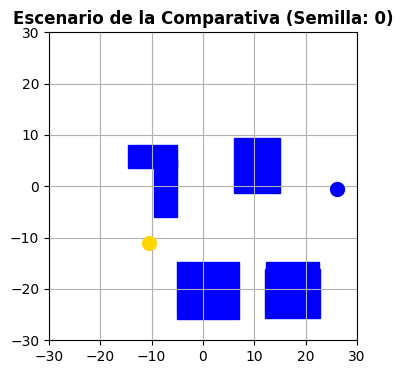


>>> EVALUANDO ESCENARIO CON 50 ITERACIONES <<<
Evaluando RRT*...
Evaluando Informed RRT*...
Evaluando BIT*...

>>> EVALUANDO ESCENARIO CON 100 ITERACIONES <<<
Evaluando RRT*...
Evaluando Informed RRT*...
Evaluando BIT*...

>>> EVALUANDO ESCENARIO CON 150 ITERACIONES <<<
Evaluando RRT*...
Evaluando Informed RRT*...
Evaluando BIT*...

>>> EVALUANDO ESCENARIO CON 200 ITERACIONES <<<
Evaluando RRT*...
Evaluando Informed RRT*...
Evaluando BIT*...

>>> EVALUANDO ESCENARIO CON 250 ITERACIONES <<<
Evaluando RRT*...
Evaluando Informed RRT*...
Evaluando BIT*...

>>> EVALUANDO ESCENARIO CON 300 ITERACIONES <<<
Evaluando RRT*...
Evaluando Informed RRT*...
Evaluando BIT*...

>>> EVALUANDO ESCENARIO CON 350 ITERACIONES <<<
Evaluando RRT*...
Evaluando Informed RRT*...
Evaluando BIT*...

>>> EVALUANDO ESCENARIO CON 400 ITERACIONES <<<
Evaluando RRT*...
Evaluando Informed RRT*...
Evaluando BIT*...

>>> EVALUANDO ESCENARIO CON 450 ITERACIONES <<<
Evaluando RRT*...
Evaluando Informed RRT*...
Evaluando B

success_rate  avg_time_s   avg_nodes  \
iterations algorithm                                             
50         RRT*                  0.361    0.006421   38.731302   
           Informed RRT*         0.361    0.011630   41.002770   
           BIT*                  0.456    0.017780   46.745614   
100        RRT*                  0.700    0.014269   76.391429   
           Informed RRT*         0.700    0.028796   80.031429   
           BIT*                  0.795    0.042024   93.783648   
150        RRT*                  0.863    0.024150  115.723059   
           Informed RRT*         0.863    0.051131  120.139050   
           BIT*                  0.873    0.074069  142.588774   
200        RRT*                  0.931    0.033684  155.682062   
           Informed RRT*         0.931    0.078641  160.700322   
           BIT*                  0.946    0.114631  191.589852   
250        RRT*                  0.964    0.047002  196.061203   
           Informed RRT*         0.964    0.110056  201.750000   
           BIT*                  0.973    0.156272  241.054471   
300        RRT*                  0.988    0.059633  236.433198   
           Informed RRT*         0.988    0.148803  242.769231   
           BIT*                  0.984    0.209113  290.753049   
350        RRT*                  0.992    0.072624  277.050403   
           Informed RRT*         0.992    0.188968  284.385081   
           BIT*                  0.992    0.266509  340.234879   
400        RRT*                  0.994    0.087890  317.944668   
           Informed RRT*         0.994    0.232454  325.958753   
           BIT*                  0.996    0.328298  389.912651   
450        RRT*                  0.995    0.107080  358.654271   
           Informed RRT*         0.995    0.278791  367.595980   
           BIT*                  0.996    0.393360  439.867470   
500        RRT*                  0.997    0.126055  399.354062   
           Informed RRT*         0.997    0.339234  409.254764   
           BIT*                  0.999    0.458565  489.626627   
550        RRT*                  0.997    0.144909  440.233701   
           Informed RRT*         0.997    0.394614  451.013039   
           BIT*                  0.999    0.533403  539.604605   
600        RRT*                  0.997    0.165147  481.052156   
           Informed RRT*         0.997    0.455301  492.826479   
           BIT*                  0.999    0.623092  589.580581   
650        RRT*                  0.997    0.182976  521.989970   
           Informed RRT*         0.997    0.516564  534.668004   
           BIT*                  0.999    0.707270  639.569570   
700        RRT*                  0.998    0.212273  562.753507   
           Informed RRT*         0.998    0.576354  576.312625   
           BIT*                  0.999    0.793737  689.543544   
750        RRT*                  0.998    0.236325  603.681363   
           Informed RRT*         0.998    0.647476  618.244489   
           BIT*                  0.999    0.885133  739.526527   
800        RRT*                  0.998    0.257879  644.705411   
           Informed RRT*         0.998    0.724879  660.190381   
           BIT*                  0.999    0.987489  789.518519   
850        RRT*                  0.998    0.289314  685.594188   
           Informed RRT*         0.998    0.806054  702.163327   
           BIT*                  0.999    1.078363  839.505506   
900        RRT*                  0.998    0.316158  726.479960   
           Informed RRT*         0.998    0.886227  744.104208   
           BIT*                  1.000    1.193594  889.453000   
950        RRT*                  0.999    0.346463  767.345345   
           Informed RRT*         0.999    0.972246  785.967968   
           BIT*                  1.000    1.305187  939.443000   
1000       RRT*                  0.999    0.377482  808.391391   
           Informed RRT*         0.999    1.059405  827.962963   


In [ ]:
# =============================================================================
# BLOQUE DE EJECUCIÓN EXPERIMENTAL DE ALTO RENDIMIENTO
# =============================================================================

# NOTA: Este bloque tiene una carga computacional muy elevada
# Tiempo estimado de ejecución: 8 horas aproximadamente.

# 1. Configuración de parámetros para la previsualización del escenario
scenario_kwargs_viz = dict(
    xmin=-30, xmax=30, ymin=-30, ymax=30, 
    robot_radius=2.5, n_obstacles_range=(3, 6), 
    size_range=(4, 12), grid_n=70, 
    min_start_goal_dist=25.0
)

# Visualización del escenario base (semilla 0) para validar la configuración del entorno
visualize_first_scenario(seed0=0, **scenario_kwargs_viz)

# 2. Configuración técnica para el análisis de convergencia masivo
scenario_kwargs = dict(
    xmin=-30, xmax=30, ymin=-30, ymax=30, 
    robot_radius=2.5, n_obstacles_range=(3, 6), 
    size_range=(4, 12), grid_n=70, 
    min_start_goal_dist=25.0, 
    edge_length=5, goal_threshold=5.0
)

# Definición del espectro de iteraciones para observar la mejora asintótica del coste
iter_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

# 3. Lanzamiento del benchmarking sistemático
# La ruta ha sido modificada para guardar los datos brutos en '../results/tests/'
df_comparativo = compare_performance_by_iterations(
    iter_values, 
    n_runs=1000, 
    filename='../results/tests/comparativa_rrt.csv', 
    **scenario_kwargs
)

# Presentación de la tabla de resultados consolidados en el notebook
display(df_comparativo)

# 📊 Visualización de Resultados y Generación de Material para la Memoria

A partir de este punto, las celdas están dedicadas exclusivamente al **análisis de los datos recolectados** y a la **generación de material gráfico** para la memoria técnica y la presentación final del proyecto.

### Objetivos de esta sección:
* **Análisis de Métricas**: Representación gráfica de la Tasa de Éxito, Tiempo de Cómputo y Longitud del Camino.
* **Estudio de Convergencia**: Visualización detallada de cómo evolucionan los algoritmos a medida que aumenta el presupuesto de iteraciones.
* **Análisis de Seguridad y Suavidad**: Comparativa del compromiso entre la optimalidad (distancia) y el margen de seguridad (*clearance*).
* **Exportación de Figuras**: Todas las gráficas se procesan con formatos adecuados para su inserción en el documento final, guardándose automáticamente en `../results/figures/`.

---

Generando imagen de escenarios de prueba...
Figura guardada en '../results/figures/scenarios_example.png'


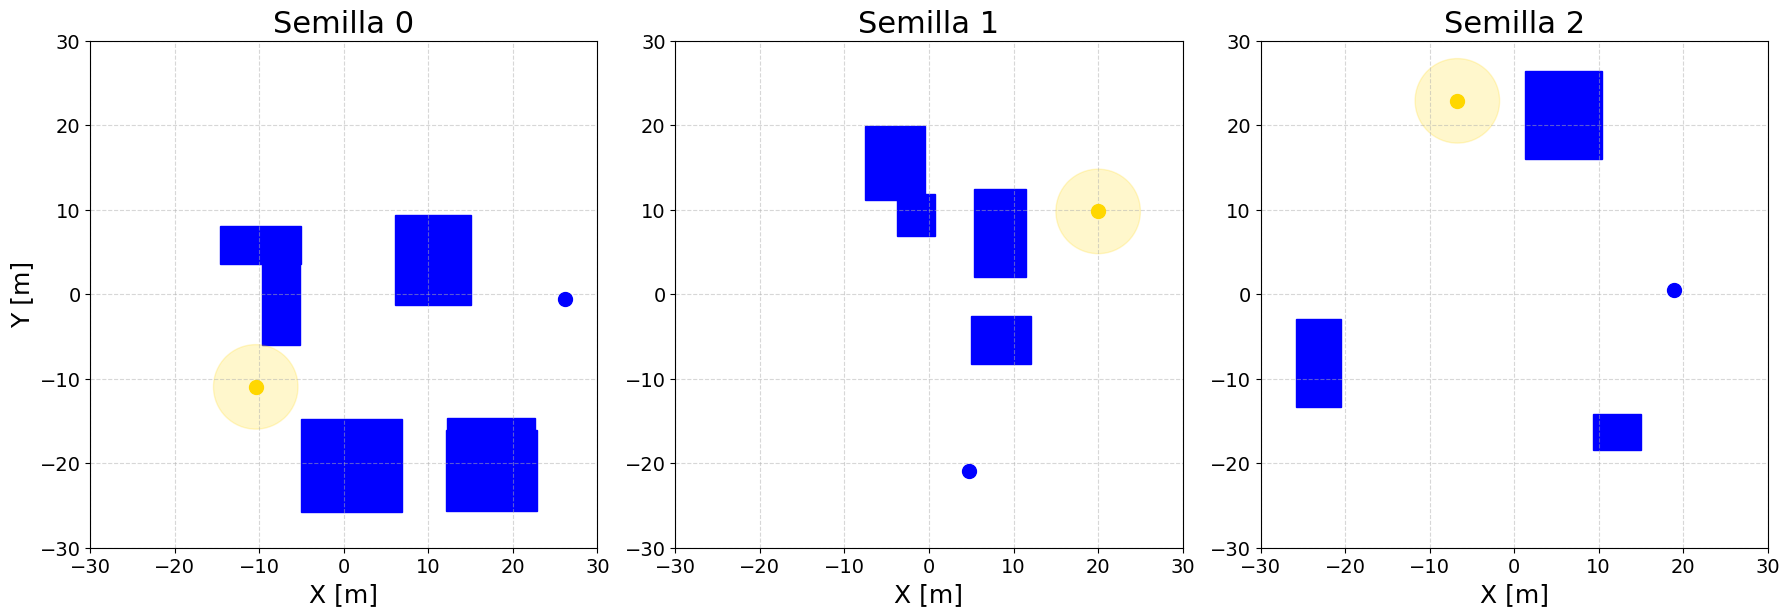

In [70]:
scenario_kwargs = dict(
    xmin=-30, xmax=30, ymin=-30, ymax=30,
    robot_radius=2.5, n_obstacles_range=(3, 6),
    size_range=(4, 12), grid_n=70,
    min_start_goal_dist=25.0
)

seeds_to_plot = [0, 1, 2]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

print("Generando imagen de escenarios de prueba...")

for i, seed in enumerate(seeds_to_plot):
    ax = axes[i]

    scenario, start, goal = generate_random_scenario(seed=seed, **scenario_kwargs)
    
    for obs in scenario.obstacles:
        obs.draw(ax)
        
    start.draw(ax, color='blue', size=10) # Punto inicial
    goal.draw(ax, color='gold', size=10) # Punto objetivo
    
    goal_region = plt.Circle((goal.x, goal.y), 5.0, color='gold', alpha=0.2)
    ax.add_patch(goal_region)
    
    ax.set_xlim(scenario.xmin, scenario.xmax)
    ax.set_ylim(scenario.ymin, scenario.ymax)
    ax.set_aspect('equal')
    ax.set_title(f"Semilla {seed}", fontsize=22)
    ax.set_xlabel("X [m]", fontsize=18)
    if i == 0:
        ax.set_ylabel("Y [m]", fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()


import os
if not os.path.exists('../results/figures/'):
    os.makedirs('../results/figures/')

plt.savefig('../results/figures/scenarios_example.png', dpi=50, bbox_inches='tight')
print("Figura guardada en '../results/figures/scenarios_example.png'")
plt.show()

Figura 5.2 guardada en '../results/figures/rrt_vs_rrtstar_comparison.png'


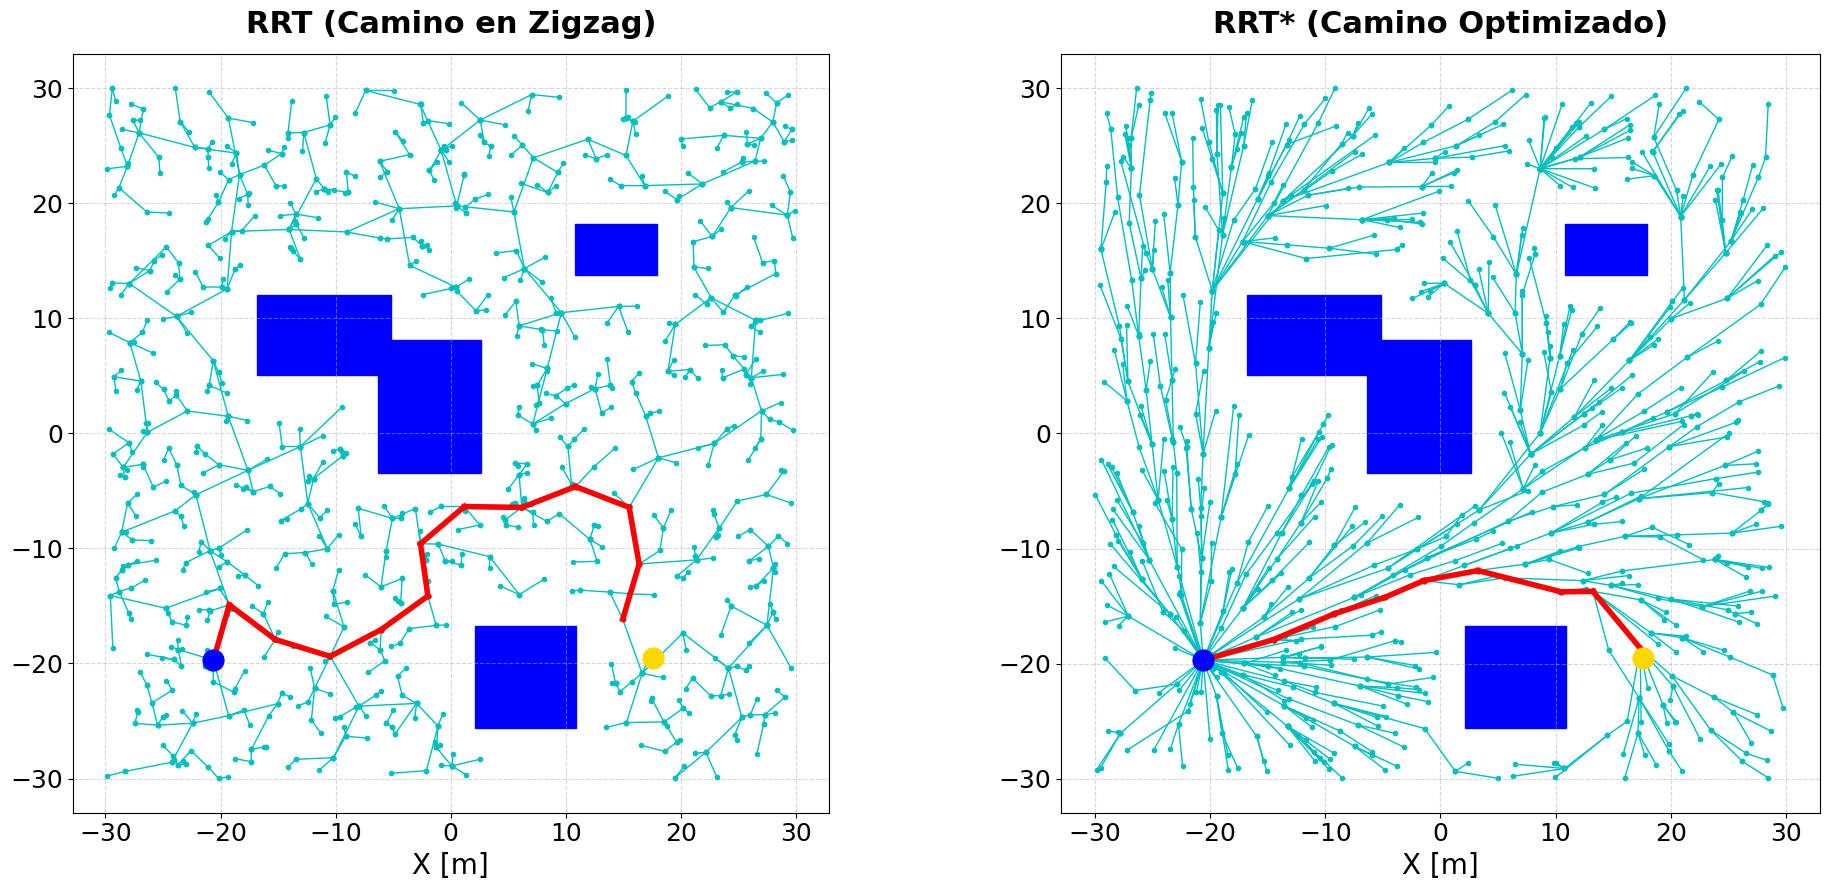

In [72]:
seed = 43  
n_iters = 1000
params = dict(
    xmin=-30, xmax=30, ymin=-30, ymax=30,
    robot_radius=2.5, n_obstacles_range=(4, 6),
    size_range=(4, 12), grid_n=70,
    min_start_goal_dist=25.0
)

scen, start, goal = generate_random_scenario(seed=seed, **params)

planner_rrt = RRT(start.x, start.y)
for _ in range(n_iters):
    planner_rrt.iterate(scen, edge_length=5, robot_radius=2.5)

planner_rrt_star = RRT_star(start.x, start.y)
for _ in range(n_iters):
    planner_rrt_star.iterate(scen, edge_length=5, robot_radius=2.5)

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

for ax, planner, title in zip(axes, [planner_rrt, planner_rrt_star], ["RRT (Camino en Zigzag)", "RRT* (Camino Optimizado)"]):
    for obs in scen.obstacles: obs.draw(ax)
    
    for node in planner.nodes:
        if node.parent:
            Segment(node.parent.point, node.point).draw(ax)
    
    path = planner.get_optimal_path(goal, threshold=5.0)
    if path:
        pts = [n.point for n in path]
        for i in range(len(pts)-1):
            Segment(pts[i], pts[i+1]).draw(ax, color='red', linewidth=4)
    
    start.draw(ax, color='blue', size=15)
    goal.draw(ax, color='gold', size=15)
    
    ax.set_title(title, fontsize=22, fontweight='bold', pad=15)
    ax.set_aspect('equal')
    ax.set_xlabel("X [m]", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
if not os.path.exists('../results/figures'): os.makedirs('../results/figures')
plt.savefig('../results/figures/rrt_vs_rrtstar_comparison.png', dpi=50, bbox_inches='tight')
print("Figura 5.2 guardada en '../results/figures/rrt_vs_rrtstar_comparison.png'")
plt.show()

Figura 5.3 guardada con éxito en '../results/figures/informed_bit_comparison.png'


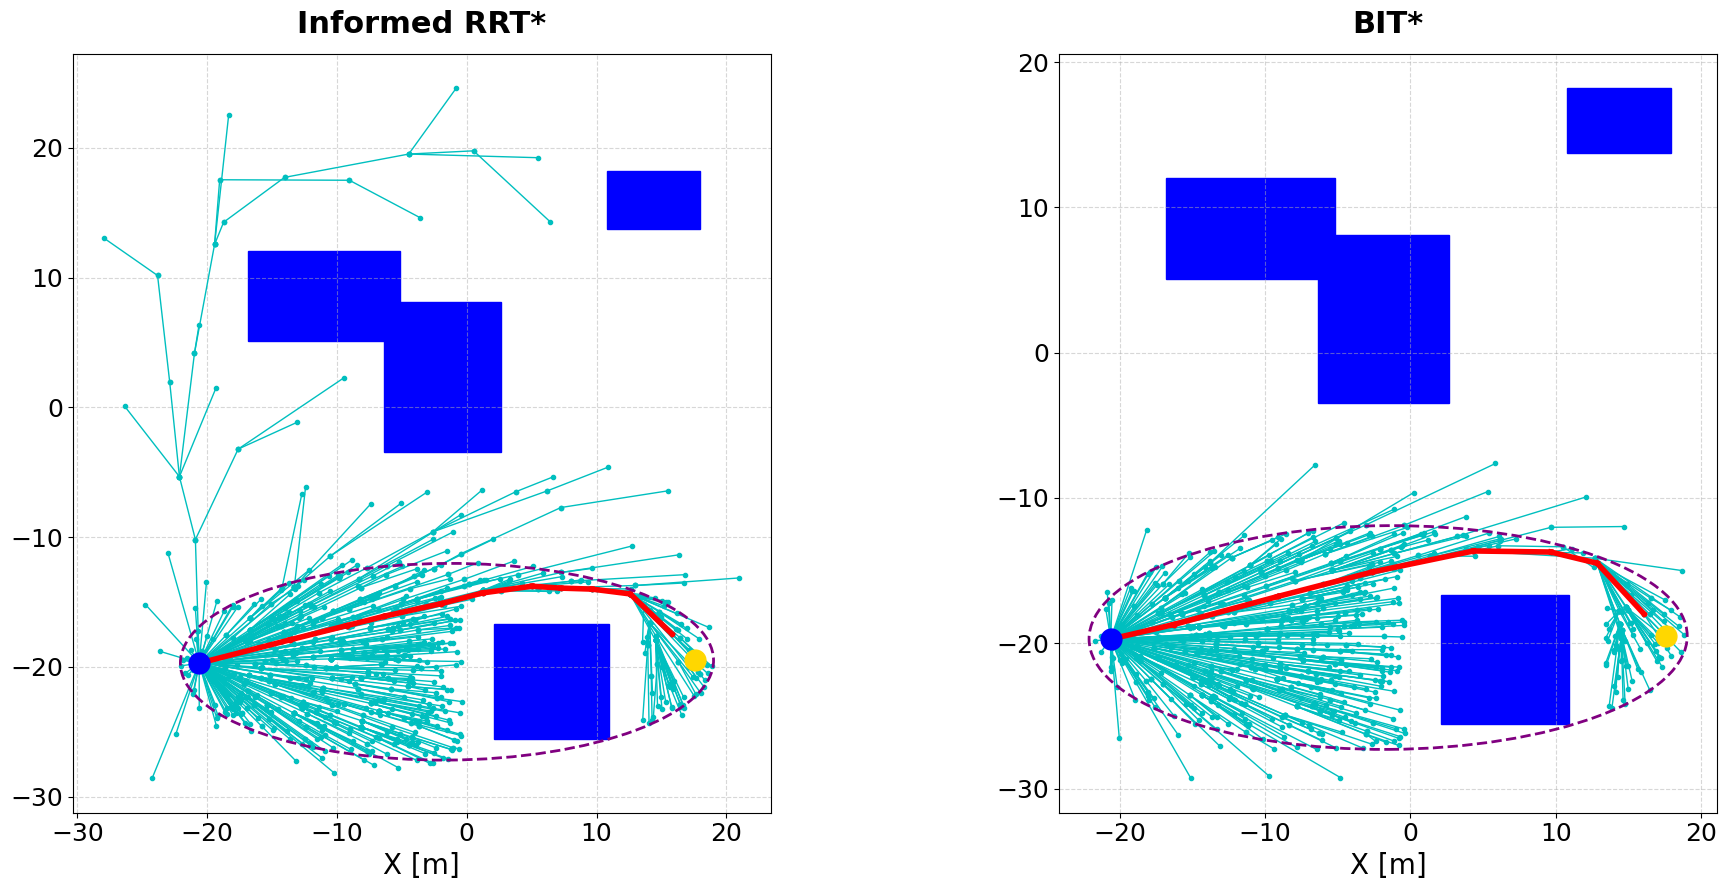

In [75]:
seed = 43  
n_iters = 1000
params = dict(
    xmin=-30, xmax=30, ymin=-30, ymax=30,
    robot_radius=2.5, n_obstacles_range=(4, 6),
    size_range=(4, 12), grid_n=70,
    min_start_goal_dist=25.0
)

scen, start, goal = generate_random_scenario(seed=seed, **params)

planner_inf = Informed_RRT_star(start.x, start.y, goal.x, goal.y, gamma=50.0)
for _ in range(n_iters):
    planner_inf.iterate(scen, edge_length=5, robot_radius=2.5)

planner_bit = BIT_star(start.x, start.y, goal.x, goal.y, batch_size=200, gamma=50.0)
for _ in range(n_iters):
    planner_bit.iterate(scen, edge_length=5, robot_radius=2.5)

fig, axes = plt.subplots(1, 2, figsize=(20, 9))
planners = [planner_inf, planner_bit]
titles = ["Informed RRT*", "BIT*"]

for ax, planner, title in zip(axes, planners, titles):
    for obs in scen.obstacles: 
        obs.draw(ax)
    
    for node in planner.nodes:
        if node.parent:
            Segment(node.parent.point, node.point).draw(ax)
    
    if planner.c_best < float('inf'):
        c_min = start.distance(goal)
        center = ((start.x + goal.x)/2, (start.y + goal.y)/2)
        angle = np.degrees(np.arctan2(goal.y - start.y, goal.x - start.x))
        width = planner.c_best
        height = np.sqrt(max(0.1, planner.c_best**2 - c_min**2))
        
        ellipse = patches.Ellipse(center, width, height, angle=angle, 
                                  edgecolor='purple', facecolor='none', 
                                  linewidth=2, linestyle='--', zorder=10)
        ax.add_patch(ellipse)

    path = planner.get_optimal_path(goal, threshold=5.0)
    if path:
        pts = [n.point for n in path]
        for i in range(len(pts)-1):
            Segment(pts[i], pts[i+1]).draw(ax, color='red', linewidth=4)
    
    start.draw(ax, color='blue', size=15)
    goal.draw(ax, color='gold', size=15)
    
    ax.set_title(title, fontsize=22, fontweight='bold', pad=15)
    ax.set_aspect('equal')
    ax.set_xlabel("X [m]", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

# Guardar figura
if not os.path.exists('../results/figures'): os.makedirs('../results/figures')
plt.savefig('../results/figures/informed_bit_comparison.png', dpi=50, bbox_inches='tight')
print("Figura 5.3 guardada con éxito en '../results/figures/informed_bit_comparison.png'")
plt.show()

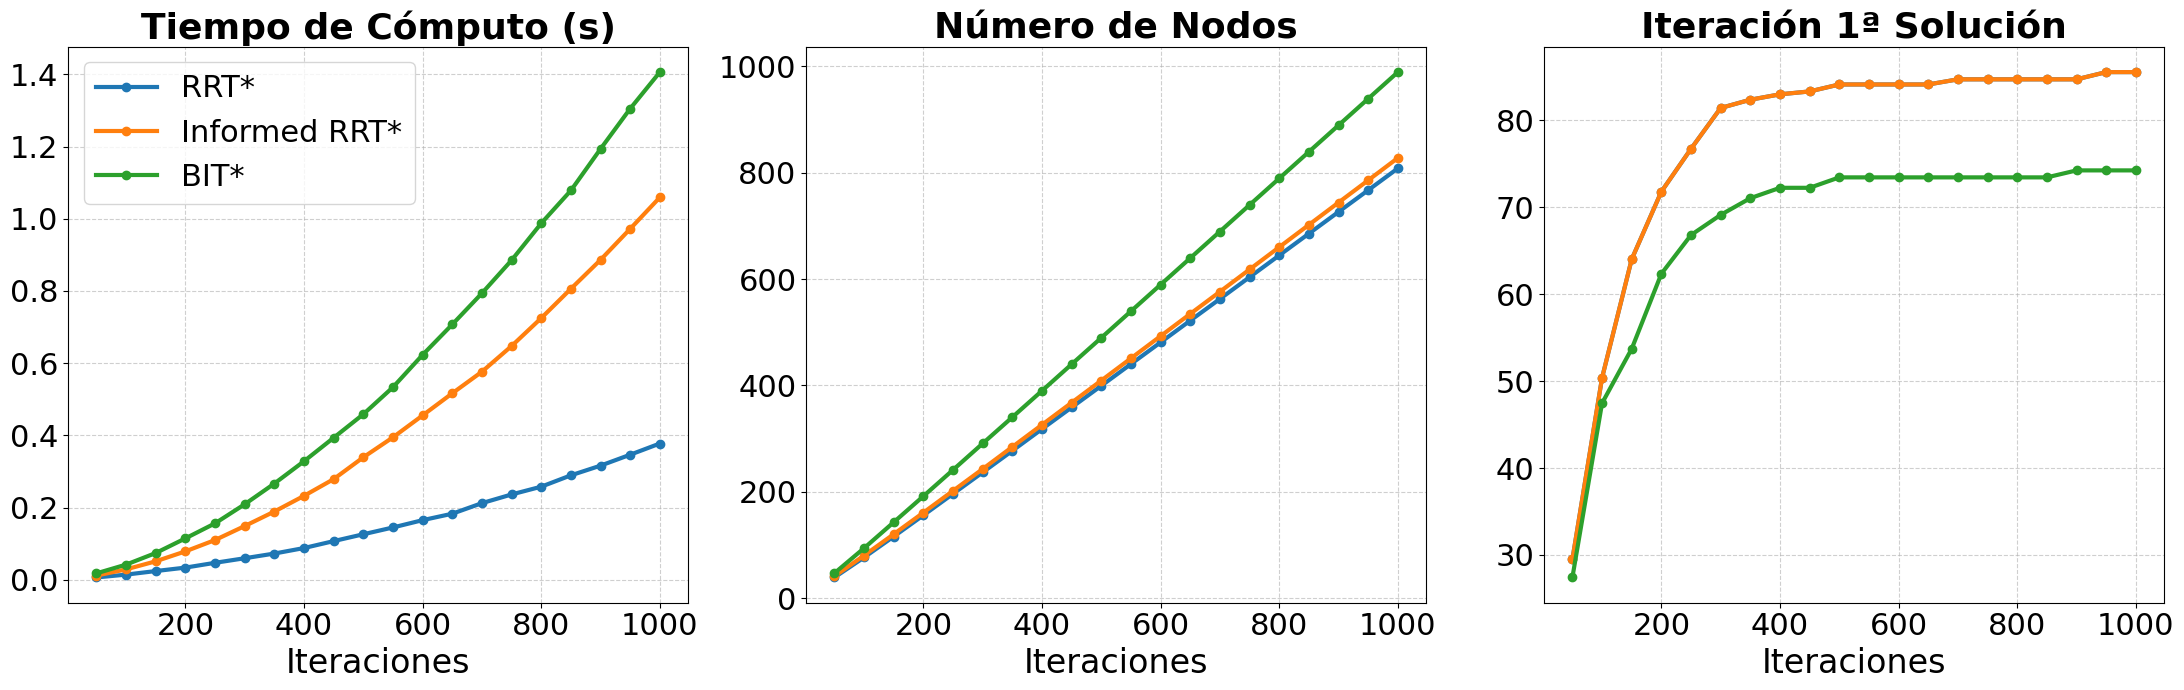

In [66]:
df = pd.read_csv('../results/tests/comparativa_rrt.csv')
algos = ['RRT*', 'Informed RRT*', 'BIT*']
df_filtered = df[df['algorithm'].isin(algos)]

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

metrics_eff = ['avg_time_s', 'avg_nodes', 'avg_first_solution_iter']
titles_eff = ['Tiempo de Cómputo (s)', 'Número de Nodos', 'Iteración 1ª Solución']

for i, metric in enumerate(metrics_eff):
    for algo in algos:
        subset = df_filtered[df_filtered['algorithm'] == algo]
        axes[i].plot(subset['iterations'], subset[metric], marker='o', linewidth=3, label=algo)
    axes[i].set_title(titles_eff[i], fontsize=26, fontweight='bold')
    axes[i].set_xlabel("Iteraciones", fontsize=24)
    axes[i].grid(True, linestyle='--', alpha=0.6)
    axes[i].tick_params(labelsize=22)

axes[0].legend(fontsize=22)
plt.tight_layout()
plt.savefig('../results/figures/metrics_efficiency.png', dpi=50)
plt.show()

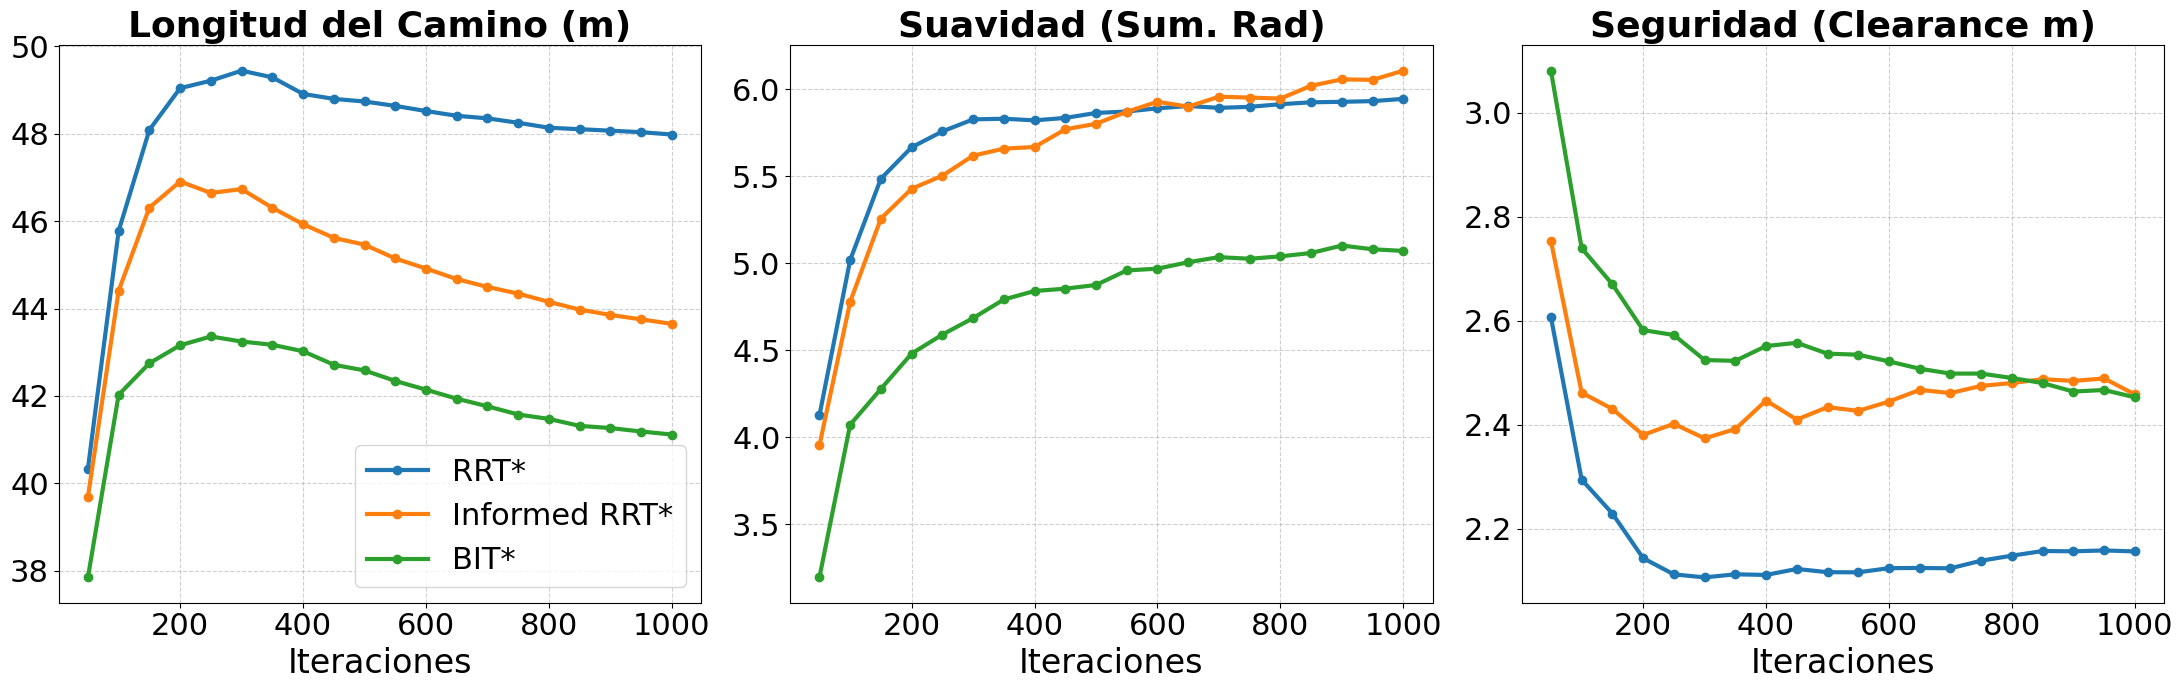

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

metrics_qual = ['avg_path_length', 'avg_smoothness_sum', 'avg_min_clearance']
titles_qual = ['Longitud del Camino (m)', 'Suavidad (Sum. Rad)', 'Seguridad (Clearance m)']

for i, metric in enumerate(metrics_qual):
    for algo in algos:
        subset = df_filtered[df_filtered['algorithm'] == algo]
        axes[i].plot(subset['iterations'], subset[metric], marker='o', linewidth=3, label=algo)
    axes[i].set_title(titles_qual[i], fontsize=26, fontweight='bold')
    axes[i].set_xlabel("Iteraciones", fontsize=24)
    axes[i].grid(True, linestyle='--', alpha=0.6)
    axes[i].tick_params(labelsize=22)

axes[0].legend(fontsize=22)
plt.tight_layout()
plt.savefig('../results/figures/metrics_quality.png', dpi=50)
plt.show()

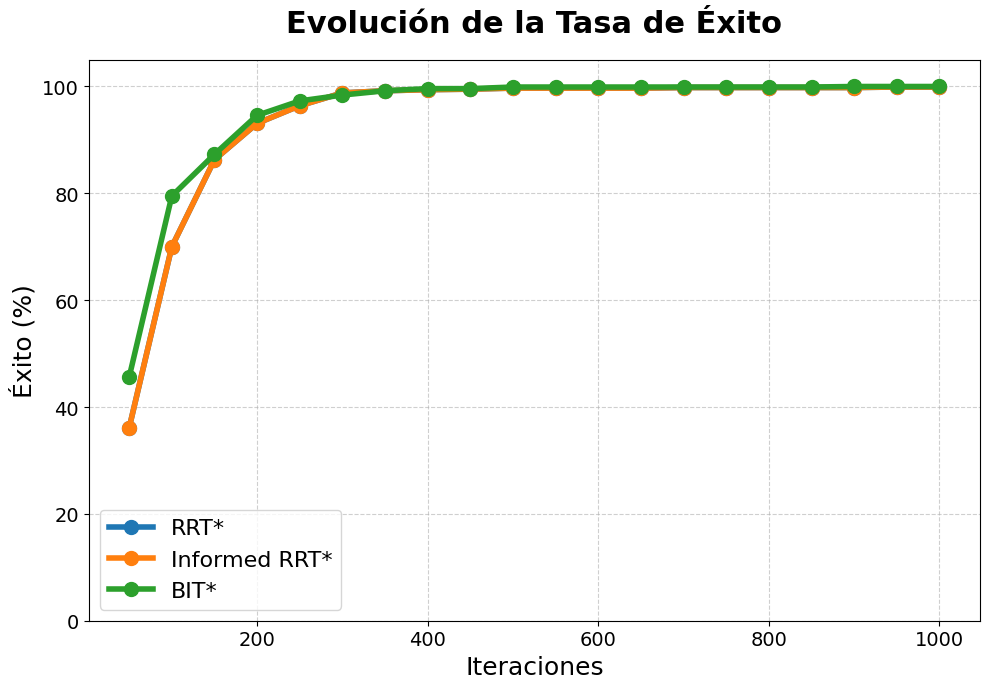

In [64]:
plt.figure(figsize=(10, 7))
for algo in algos:
    subset = df_filtered[df_filtered['algorithm'] == algo]
    plt.plot(subset['iterations'], subset['success_rate'] * 100, marker='o', linewidth=4, markersize=10, label=algo)

plt.title("Evolución de la Tasa de Éxito", fontsize=22, fontweight='bold', pad=20)
plt.xlabel("Iteraciones", fontsize=18)
plt.ylabel("Éxito (%)", fontsize=18)
plt.ylim(0, 105)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('../results/figures/metrics_success.png', dpi=50)
plt.show()

Iniciando simulación extrema...
-> Procesando Informed RRT*...
-> Procesando BIT*...
Figura 5.5 guardada con éxito.


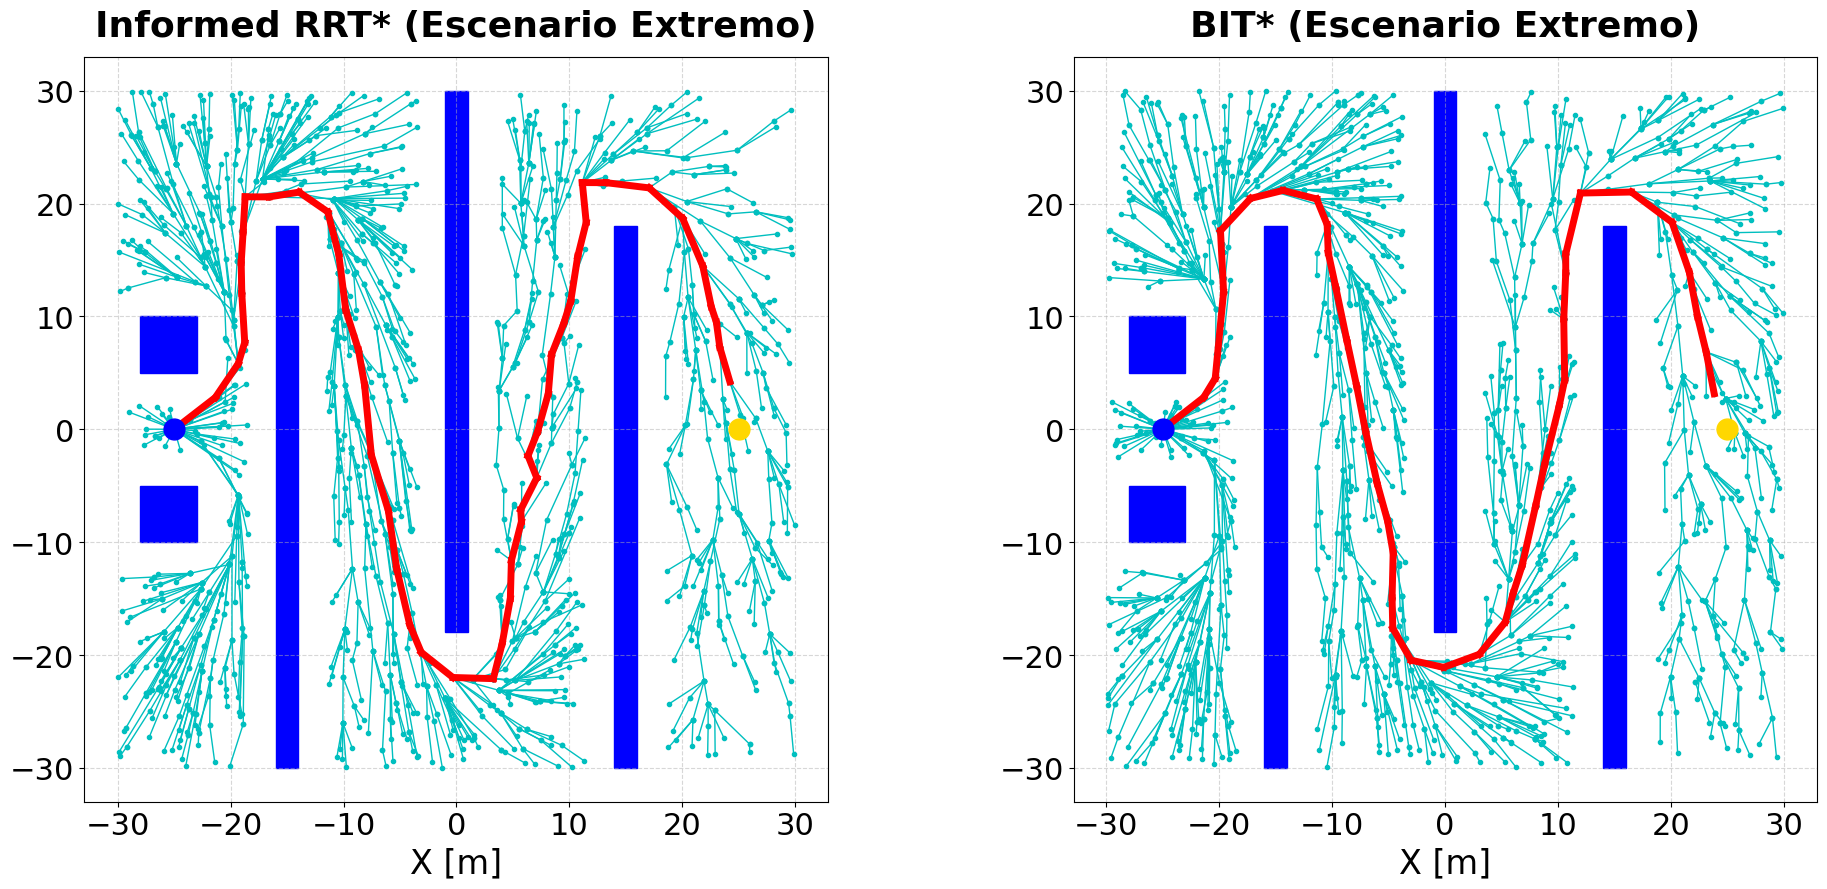

In [74]:
obs_extreme = [
    # Muro 1 (Izquierda): Hueco arriba
    Obstacle(-16, -30, 2, 48), # x:[-16,-14], y:[-30,18]
    
    # Muro 2 (Centro): Hueco abajo
    Obstacle(-1, -18, 2, 48),  # x:[-1,1], y:[-18,30]
    
    # Muro 3 (Derecha): Hueco arriba
    Obstacle(14, -30, 2, 48),  # x:[14,16], y:[-30,18]
    
    # Bloque de distracción al inicio
    Obstacle(-28, 5, 5, 5),
    Obstacle(-28, -10, 5, 5)
]

scen_extreme = Scenario(obs_extreme, -30, 30, -30, 30)
start_e = Point(-25, 0)
goal_e = Point(25, 0)

# Parámetros de alta dificultad
n_iters_extreme = 2500 # Más iteraciones para ver la convergencia
edge_l = 4.0
robot_r = 2.5

# 2. Ejecutar Informed RRT* vs BIT*
planner_inf_e = Informed_RRT_star(start_e.x, start_e.y, goal_e.x, goal_e.y, gamma=50.0)
planner_bit_e = BIT_star(start_e.x, start_e.y, goal_e.x, goal_e.y, batch_size=30, gamma=50.0)

print("Iniciando simulación extrema...")
print("-> Procesando Informed RRT*...")
for _ in range(n_iters_extreme): planner_inf_e.iterate(scen_extreme, edge_l, robot_r)

print("-> Procesando BIT*...")
for _ in range(n_iters_extreme): planner_bit_e.iterate(scen_extreme, edge_l, robot_r)

# 3. Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(20, 9))
planners = [planner_inf_e, planner_bit_e]
titles = ["Informed RRT* (Escenario Extremo)", "BIT* (Escenario Extremo)"]

for ax, planner, title in zip(axes, planners, titles):
    # Dibujar obstáculos
    for obs in scen_extreme.obstacles: obs.draw(ax)
    
    # Dibujar árbol (Estilo unificado sin transparencias para Overleaf)
    for node in planner.nodes:
        if node.parent: Segment(node.parent.point, node.point).draw(ax)
    
    # Dibujar elipse de búsqueda (en púrpura)
    if planner.c_best < float('inf'):
        c_min = start_e.distance(goal_e)
        center = ((start_e.x + goal_e.x)/2, (start_e.y + goal_e.y)/2)
        angle = np.degrees(np.arctan2(goal_e.y - start_e.y, goal_e.x - start_e.x))
        width = planner.c_best
        height = np.sqrt(max(0.1, planner.c_best**2 - c_min**2))

    # Dibujar camino óptimo (Rojo grueso)
    path = planner.get_optimal_path(goal_e, threshold=5.0)
    if path:
        pts = [n.point for n in path]
        for i in range(len(pts)-1):
            Segment(pts[i], pts[i+1]).draw(ax, color='red', linewidth=5)
            
    start_e.draw(ax, color='blue', size=15)
    goal_e.draw(ax, color='gold', size=15)
    
    ax.set_title(title, fontsize=26, fontweight='bold', pad=15)
    ax.set_aspect('equal')
    ax.set_xlabel("X [m]", fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
if not os.path.exists('../results/figures'): os.makedirs('../results/figures')
plt.savefig('../results/figures/extreme_comparison.png', dpi=50, bbox_inches='tight')
print("Figura 5.5 guardada con éxito.")
plt.show()

In [41]:
# =============================================================================
# SIMULACIÓN EXTREMA CON RECOLECCIÓN DE DATOS DE CONVERGENCIA
# =============================================================================

# Parámetros (Mismos del laberinto anterior)
n_iters_extreme = 2500
step_save = 50 # Guardar coste cada 50 iteraciones
edge_l = 4.0
robot_r = 2.5

# Reiniciar planificadores
planner_inf_e = Informed_RRT_star(start_e.x, start_e.y, goal_e.x, goal_e.y, gamma=50.0)
planner_bit_e = BIT_star(start_e.x, start_e.y, goal_e.x, goal_e.y, batch_size=30, gamma=50.0)

iters_axis = []
costs_inf = []
costs_bit = []

print("Iniciando simulación comparativa de coste...")

for i in range(1, n_iters_extreme + 1):
    planner_inf_e.iterate(scen_extreme, edge_l, robot_r)
    planner_bit_e.iterate(scen_extreme, edge_l, robot_r)
    
    if i % step_save == 0:
        iters_axis.append(i)
        # Informed RRT* Cost
        c_inf = planner_inf_e.c_best if planner_inf_e.c_best < float('inf') else None
        costs_inf.append(c_inf)
        # BIT* Cost
        c_bit = planner_bit_e.c_best if planner_bit_e.c_best < float('inf') else None
        costs_bit.append(c_bit)

print("Simulación completada.")

Iniciando simulación comparativa de coste...
Simulación completada.


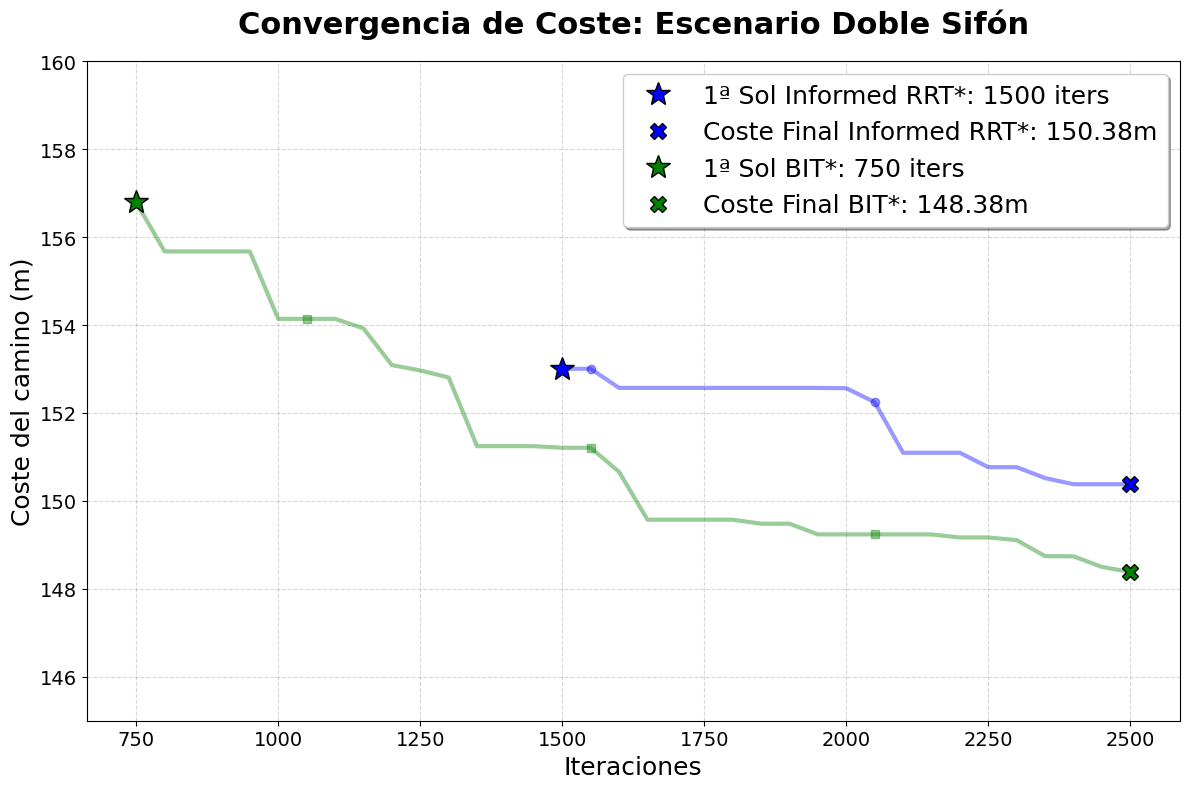

In [42]:
# =============================================================================
# GENERACIÓN DE FIGURA 5.6: CONVERGENCIA CON HITOS INICIALES Y FINALES
# =============================================================================
plt.figure(figsize=(12, 8))

# 1. Graficar las líneas de tendencia
plt.plot(iters_axis, costs_inf, color='blue', linewidth=3, marker='o', markevery=10, alpha=0.4, label='_nolegend_')
plt.plot(iters_axis, costs_bit, color='green', linewidth=3, marker='s', markevery=10, alpha=0.4, label='_nolegend_')

# 2. Hitos de Primera y Última Solución
configs = [
    (costs_inf, 'Informed RRT*', 'blue'),
    (costs_bit, 'BIT*', 'green')
]

for costs, label, color in configs:
    if any(v is not None for v in costs):
        # --- Hito Inicial ---
        idx_init = next(i for i, v in enumerate(costs) if v is not None)
        plt.plot(iters_axis[idx_init], costs[idx_init], marker='*', color=color, 
                 markersize=18, markeredgecolor='black', zorder=25, linestyle='None',
                 label=f'1ª Sol {label}: {iters_axis[idx_init]} iters')
        
        # --- Hito Final (Marca final) ---
        idx_final = len(costs) - 1
        last_cost = costs[idx_final]
        plt.plot(iters_axis[idx_final], last_cost, marker='X', color=color, 
                 markersize=12, markeredgecolor='black', zorder=25, linestyle='None',
                 label=f'Coste Final {label}: {last_cost:.2f}m')

# 3. AJUSTE DEL EJE Y (Rango solicitado 145 - 160)
plt.ylim(145, 160) 

# 4. Estética Final
plt.title("Convergencia de Coste: Escenario Doble Sifón", fontsize=22, fontweight='bold', pad=20)
plt.xlabel("Iteraciones", fontsize=18)
plt.ylabel("Coste del camino (m)", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Leyenda un poco más pequeña para que quepan las 4 entradas nuevas + las líneas
plt.legend(fontsize=18, loc='upper right', frameon=True, shadow=True, facecolor='white')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../results/figures/extreme_convergence.png', dpi=100, bbox_inches='tight')
plt.show()

Figura 5.7 guardada con éxito.


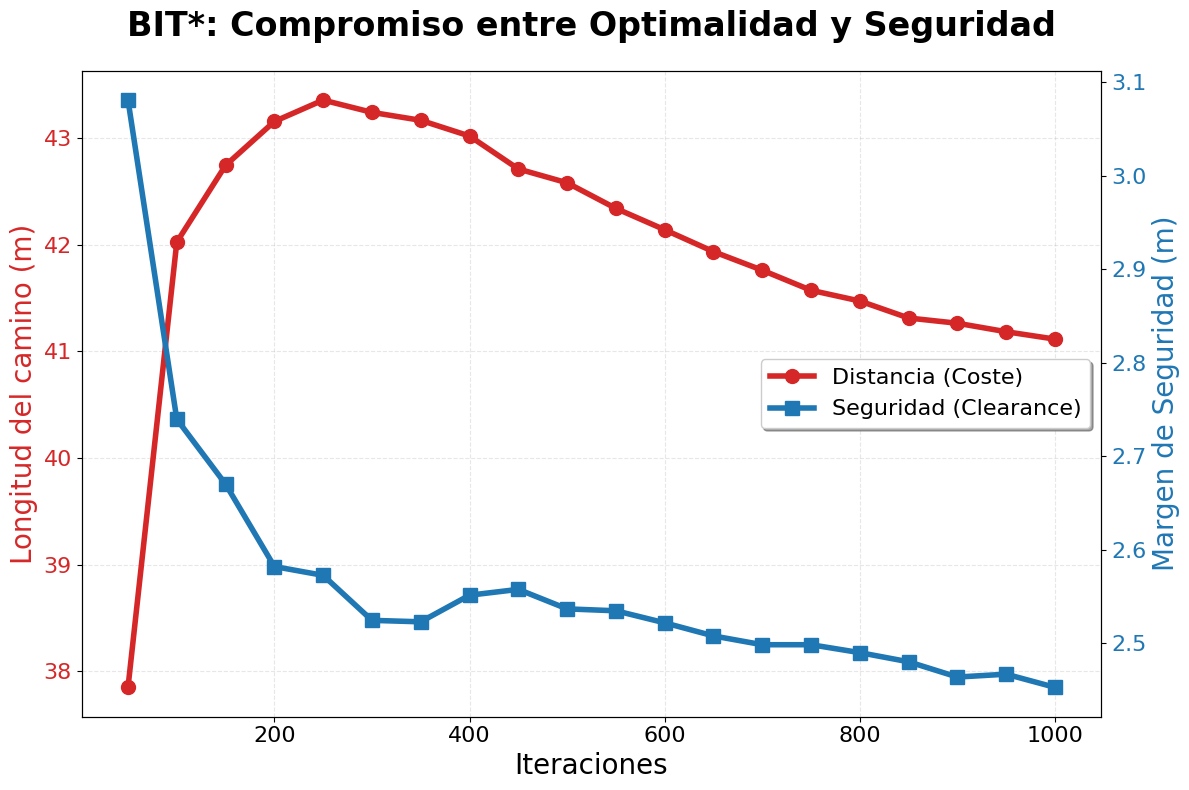

In [67]:
# =============================================================================
# GENERACIÓN DE FIGURA 5.7: GRÁFICO ÚNICO DE COMPROMISO (TRADE-OFF)
# =============================================================================

# 1. Carga de datos
df = pd.read_csv('../results/tests/comparativa_rrt.csv')
# Usamos BIT* como referencia principal para ilustrar la sobre-optimización
data_bit = df[df['algorithm'] == 'BIT*'].sort_values('iterations')

fig, ax1 = plt.subplots(figsize=(12, 8))

# --- EJE IZQUIERDO: LONGITUD DEL CAMINO ---
color_path = 'tab:red'
ax1.set_xlabel('Iteraciones', fontsize=20)
ax1.set_ylabel('Longitud del camino (m)', color=color_path, fontsize=20)
ax1.plot(data_bit['iterations'], data_bit['avg_path_length'], 
         color=color_path, marker='o', linewidth=4, markersize=10, label='Distancia (Coste)')
ax1.tick_params(axis='y', labelcolor=color_path, labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.grid(True, linestyle='--', alpha=0.3)

# --- EJE DERECHO: MARGEN DE SEGURIDAD (CLEARANCE) ---
ax2 = ax1.twinx()  # Crear el segundo eje que comparte el mismo eje X
color_clear = 'tab:blue'
ax2.set_ylabel('Margen de Seguridad (m)', color=color_clear, fontsize=20)
ax2.plot(data_bit['iterations'], data_bit['avg_min_clearance'], 
         color=color_clear, marker='s', linewidth=4, markersize=10, label='Seguridad (Clearance)')
ax2.tick_params(axis='y', labelcolor=color_clear, labelsize=16)

# --- ESTÉTICA FINAL ---
plt.title("BIT*: Compromiso entre Optimalidad y Seguridad", fontsize=24, fontweight='bold', pad=25)

# Combinar leyendas de ambos ejes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=16, frameon=True, shadow=True)

plt.tight_layout()

# Guardar figura
if not os.path.exists('../results/figures'): os.makedirs('../results/figures')
plt.savefig('../results/figures/tradeoff_analysis.png', dpi=50, bbox_inches='tight')
print("Figura 5.7 guardada con éxito.")
plt.show()

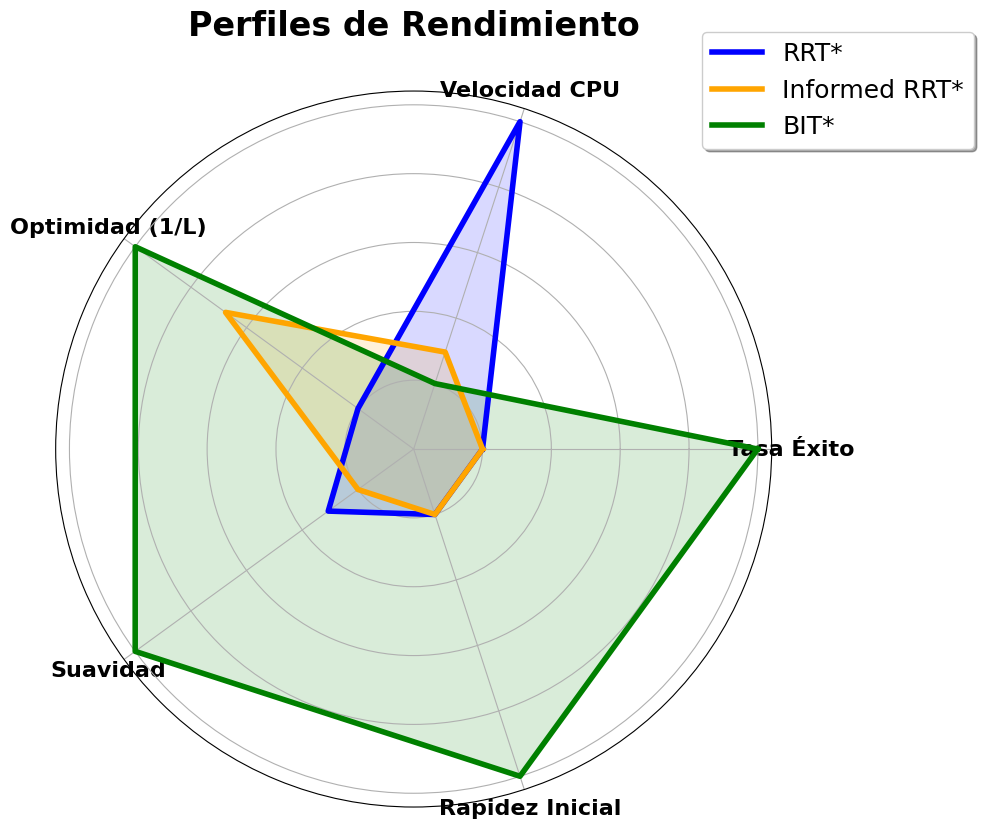

In [68]:
# =============================================================================
# GENERACIÓN DE FIGURA 5.8: GRÁFICA DE RADAR (SÍNTESIS SIN SEGURIDAD)
# =============================================================================
from math import pi

# 1. Preparación de datos (usamos los promedios finales a 1000 iteraciones)
df = pd.read_csv('../results/tests/comparativa_rrt.csv')
final_data = df[df['iterations'] == 1000].copy()

# Definimos las métricas a comparar (Normalizadas: Mayor es Mejor)
# Invertimos Tiempo, Path Length, Smoothness e Iteración de 1ª Sol
final_data['inv_time'] = 1 / final_data['avg_time_s']
final_data['inv_path'] = 1 / final_data['avg_path_length']
final_data['inv_smoothness'] = 1 / final_data['avg_smoothness_sum']
final_data['inv_init'] = 1 / final_data['avg_first_solution_iter']

categories = ['Tasa Éxito', 'Velocidad CPU', 'Optimidad (1/L)', 'Suavidad', 'Rapidez Inicial']
N = len(categories)

# Normalización de 0.1 a 1.0 para que el gráfico no colapse en el centro
def normalize(col): 
    return (col - col.min()) / (col.max() - col.min() + 1e-6) * 0.8 + 0.2

plot_data = pd.DataFrame({
    'Tasa Éxito': normalize(final_data['success_rate']),
    'Velocidad CPU': normalize(final_data['inv_time']),
    'Optimidad (1/L)': normalize(final_data['inv_path']),
    'Suavidad': normalize(final_data['inv_smoothness']),
    'Rapidez Inicial': normalize(final_data['inv_init'])
})
plot_data['algorithm'] = final_data['algorithm'].values

# 2. Configuración del gráfico de Radar
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
colors = {'RRT*': 'blue', 'Informed RRT*': 'orange', 'BIT*': 'green'}

for i, row in plot_data.iterrows():
    values = row[categories].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=4, label=row['algorithm'], color=colors[row['algorithm']])
    ax.fill(angles, values, color=colors[row['algorithm']], alpha=0.15)

# Estética Profesional
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=16, fontweight='bold')
ax.set_yticklabels([]) 
plt.title("Perfiles de Rendimiento", fontsize=24, fontweight='bold', pad=40)
plt.legend(bbox_to_anchor=(1.3, 1.1), fontsize=18, shadow=True)

plt.tight_layout()
if not os.path.exists('../results/figures'): os.makedirs('../results/figures')
plt.savefig('../results/figures/performance_radar.png', dpi=50, bbox_inches='tight')
plt.show()